# Utilisation du lexicon-based method

Nous allons utiliser la méthode du "lexicon-based" grâce a nltk vader. On pourra ainsi attribuer un score à chaque mot et calculer une valeur à chaque revue.

In [1]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.sentiment.util import * 
import re 
import string

### Import des données

In [2]:
df = pd.read_csv(r"C:\Users\Simplon\Desktop\Travaux python\Texte analyze\Sentiment analyses\women clothing reviews\Womens Clothing E-Commerce Reviews.csv")
df = df.drop(df.columns[0], axis=1)

In [3]:
df

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...
23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [4]:
print(type(df['Review Text']))

<class 'pandas.core.series.Series'>


## EDA

#### Distribution des notes

<AxesSubplot:xlabel='Recommended IND'>

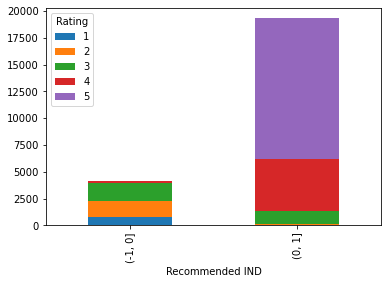

In [5]:
df.groupby(['Rating', pd.cut(df['Recommended IND'], np.arange(-1,2,1))])\
       .size()\
       .unstack(0)\
       .plot.bar(stacked=True)

On peut voir que les personnes ayant mis un score élevé, et plus précisément 4 et 5, ont tendance à laisser une recommendation. Nous pourrions utiliser cette colonne pour améliorer notre modèle

#### Valeurs manquantes

In [6]:
df.isnull().sum()

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

**Meilleur visualisation :**

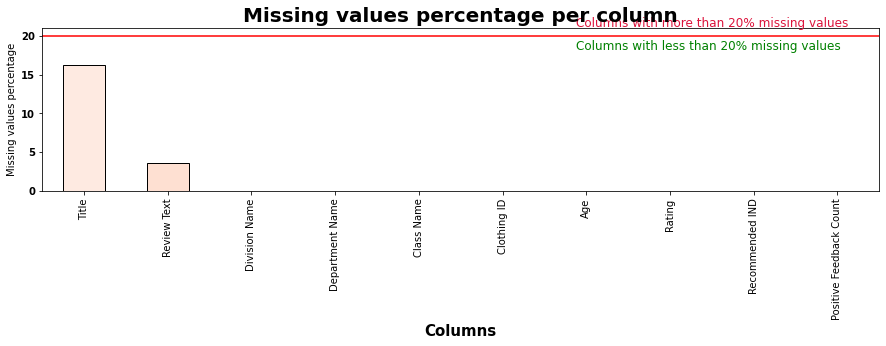

In [7]:
def msv_1(data, thresh = 20, color = 'black', edgecolor = 'black', height = 3, width = 15):
    
    plt.figure(figsize = (width, height))
    percentage = (data.isnull().mean()) * 100
    percentage.sort_values(ascending = False).plot.bar(color = color, edgecolor = edgecolor)
    plt.axhline(y = thresh, color = 'r', linestyle = '-')
    
    plt.title('Missing values percentage per column', fontsize=20, weight='bold' )
    
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh+2.5, f'Columns with more than {thresh}% missing values', fontsize=12, color='crimson',
         ha='left' ,va='top')
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh - 0.5, f'Columns with less than {thresh}% missing values', fontsize=12, color='green',
         ha='left' ,va='top')
    plt.xlabel('Columns', size=15, weight='bold')
    plt.ylabel('Missing values percentage')
    plt.yticks(weight ='bold')
    
    return plt.show()
msv_1(df, 20, color=sns.color_palette('Reds',15))

On peut voir qu'il manque des données dans "Title" et "Review Text". Ce sont pourtant les deux données qui nous sont le plus utile.

Nous allons créer une colonne qui regroupe les deux données, le titre est lui aussi important. Naive Bayes ne portera pas d'importance à l'ordre des mots.

On pourra ensuite enlever les lignes avec cette nouvelle colonne vide

In [8]:
df.dropna(subset=['Title', 'Review Text'], how='all', inplace=True)

In [9]:
#df['Title'] = df['Title'].astype(str)
df['Title'] = df['Title'].replace('nan',' ')

df['Entire Review']=df['Title']+(' ')+df['Review Text']

df.drop(columns=['Title', 'Review Text'], axis=1, inplace=True)
df.dropna(inplace=True)
df.reset_index(inplace=True)

In [10]:
df

,index,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Entire Review
0,2,1077,60,3,0,0,General,Dresses,Dresses,Some major design flaws I had such high hopes ...
1,3,1049,50,5,1,0,General Petite,Bottoms,Pants,"My favorite buy! I love, love, love this jumps..."
2,4,847,47,5,1,6,General,Tops,Blouses,Flattering shirt This shirt is very flattering...
3,5,1080,49,2,0,4,General,Dresses,Dresses,Not for the very petite I love tracy reese dre...
4,6,858,39,5,1,1,General Petite,Tops,Knits,Cagrcoal shimmer fun I aded this in my basket ...
...,...,...,...,...,...,...,...,...,...,...
19657,23481,1104,34,5,1,0,General Petite,Dresses,Dresses,Great dress for many occasions I was very happ...
19658,23482,862,48,3,1,0,General Petite,Tops,Knits,Wish it was made of cotton It reminds me of ma...
19659,23483,1104,31,3,0,1,General Petite,Dresses,Dresses,"Cute, but see through This fit well, but the t..."
19660,23484,1084,28,3,1,2,General,Dresses,Dresses,"Very cute dress, perfect for summer parties an..."


### Transformation des reviews en listes

In [11]:
sentences = list(df['Entire Review'])
type(sentences)

list

In [12]:
sentences

['Some major design flaws I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c',
 "My favorite buy! I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",
 'Flattering shirt This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!',
 'Not for the very petite I love tracy reese dresses, but this one is not for the very petite. i am just under 

### Importation de vader (pour l'attribution de score sur chaque mot...) 

In [13]:
#import nltk
#nltk.download('vader_lexicon')

In [14]:
#Analyze sentiment with vader

#sia = SIA()
#scores = [] #Create a new list with the scores, positive, negative and neutral. As a well as compound which is like the avg

#for sentence in sentences: #create a list iterator
#        pol_score = sia.polarity_scores(str(sentence)) #put sentence inside the function for vader to calculate sentiment
#        pol_score['sentences'] = sentence #take that part of the dictionary
#        scores.append(pol_score) #Append or add your new polarity scores to the original list with just the tweets or sentences

### Création dataframe avec les scores

In [15]:
#df2 = pd.DataFrame.from_records(scores)
#df2['nature']=np.where(df2['compound']>= 0.5, 'Positif','Négatif')

In [16]:
#df2

### Revue, allant du plus négatif au plus positif

In [17]:
#df_indices = pd.DataFrame()
#df_indices['Indices']=np.argsort(df2['compound'])

In [18]:
#df_indices

Le score moyen est très élevé, difficile de savoir quel phrase est négative ou positive réellement. Nous pourrons aussi ajouter le titre pour aider ainsi que le score donné par l'utilisateur

## Naive Bayes 

Nous avons déjà la donnée, qui est traité. Il va falloir effectuer les étapes suivantes :
    - Vectorisation (avec tf-idf)

### Vectorization

In [54]:
count_vector = CountVectorizer()
tfidf_vector = TfidfVectorizer()

In [55]:
x = df['Entire Review'].values
y = df['Recommended IND'].values

In [56]:
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size=0.2,random_state=0)

In [57]:
a = pd.DataFrame(y_test)

In [58]:
a.value_counts()

1    3218
0     715
dtype: int64

In [59]:
X_train_counts = count_vector.fit_transform(X_train)

In [60]:
b=pd.DataFrame(X_train_counts.toarray(), columns=count_vector.get_feature_names())

In [61]:
b

,00,00p,02,03,03dd,0in,0p,0petite,0r,0verall,...,zips,zoe,zombie,zone,zoolander,zoom,zooming,zowie,zuma,ã¼ber
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15724,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15725,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15726,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15727,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
X_train_tfidf = tfidf_vector.fit_transform(X_train)

In [63]:
tfidf_vector

TfidfVectorizer()

In [64]:
c = pd.DataFrame(X_train_tfidf.toarray() , columns = tfidf_vector.get_feature_names())

In [78]:
tfidf_vector.vocabulary_

{'cool': 2812,
 'and': 839,
 'casual': 2131,
 'this': 11467,
 'top': 11630,
 'is': 6023,
 'nice': 7535,
 'piece': 8311,
 'to': 11594,
 'transition': 11710,
 'into': 5968,
 'fall': 4287,
 'it': 6039,
 'goes': 5042,
 'well': 12486,
 'with': 12640,
 'jeans': 6104,
 'but': 1953,
 'could': 2873,
 'also': 784,
 'be': 1325,
 'dressed': 3704,
 'up': 12111,
 'black': 1536,
 'pants': 8051,
 'simply': 10146,
 'beautiful': 1356,
 'dress': 3702,
 'would': 12724,
 'recommend': 9058,
 'was': 12385,
 'short': 10033,
 'on': 7751,
 'me': 6996,
 'tall': 11240,
 'not': 7611,
 'the': 11404,
 'midi': 7110,
 'hoping': 5550,
 'for': 4686,
 'little': 6607,
 'too': 11624,
 'low': 6741,
 'cut': 3085,
 'much': 7345,
 'cleavage': 2419,
 'cup': 3048,
 'since': 10150,
 'paid': 8003,
 'full': 4825,
 'price': 8671,
 'have': 5321,
 'completely': 2641,
 'pleased': 8422,
 'my': 7393,
 'purchase': 8837,
 'reason': 9018,
 'will': 12592,
 'return': 9351,
 'maybe': 6988,
 'if': 5703,
 'had': 5224,
 'bought': 1714,
 'sale': 9

In [65]:
c

,00,00p,02,03,03dd,0in,0p,0petite,0r,0verall,...,zips,zoe,zombie,zone,zoolander,zoom,zooming,zowie,zuma,ã¼ber
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
X_test_counts = count_vector.transform(X_test)

In [67]:
X_test_tfidf = tfidf_vector.transform(X_test)

In [68]:
X_train_tfidf.shape

(15729, 12889)

In [69]:
X_test_tfidf.shape

(3933, 12889)

In [70]:
X_test

array(["Terrible quality of material I ordered the coral/peach version in size 16. it ran small, especially compared to other size 14 or 16 maeve blouses i've purchased. very tight throughout the blouse. the product photos looked so nice compared to what arrived. the material was extremely cheap in quality. it wrinkled terribly. the bow pulled the material down which obscured the look of the eyelet. the idea of this was perfect for my style. unfortunately, the poor choice in material & poor fit made this a return for me.",
       'Always active... I love these leggings so much i bought them in every color/design!!! they are amazing!\nsuper stretchy and great for an active lifestyle be it pilates, yoga, playing with kids at the park or coffe with the girls.',
       'Loved it so much i bought it in the wrong size So, when i first found this dress it was already on sale and sold out in petites. for reference i am 5\'2" and currently weighing in at about 108, and my bust is a 32d. the sto

In [71]:
X_test_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### NB

In [72]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [73]:
y_pred = model.predict(X_test_tfidf)

In [74]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.02      1.00      0.03        11
           1       1.00      0.82      0.90      3922

    accuracy                           0.82      3933
   macro avg       0.51      0.91      0.47      3933
weighted avg       1.00      0.82      0.90      3933



In [36]:
y_test

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)